# Hidden Figures 2

A simulation of landing sequence on Mars for the Dragon 2 Capsule by Sparsh Bansal and Argyris Kriezis

# Question

# What is the position and velocity of the space capsule (SpaceX Dragon 2 capsule) w.r.t Mars at which it should begin propulsive landing by firing its thrusters in the most efficient way?

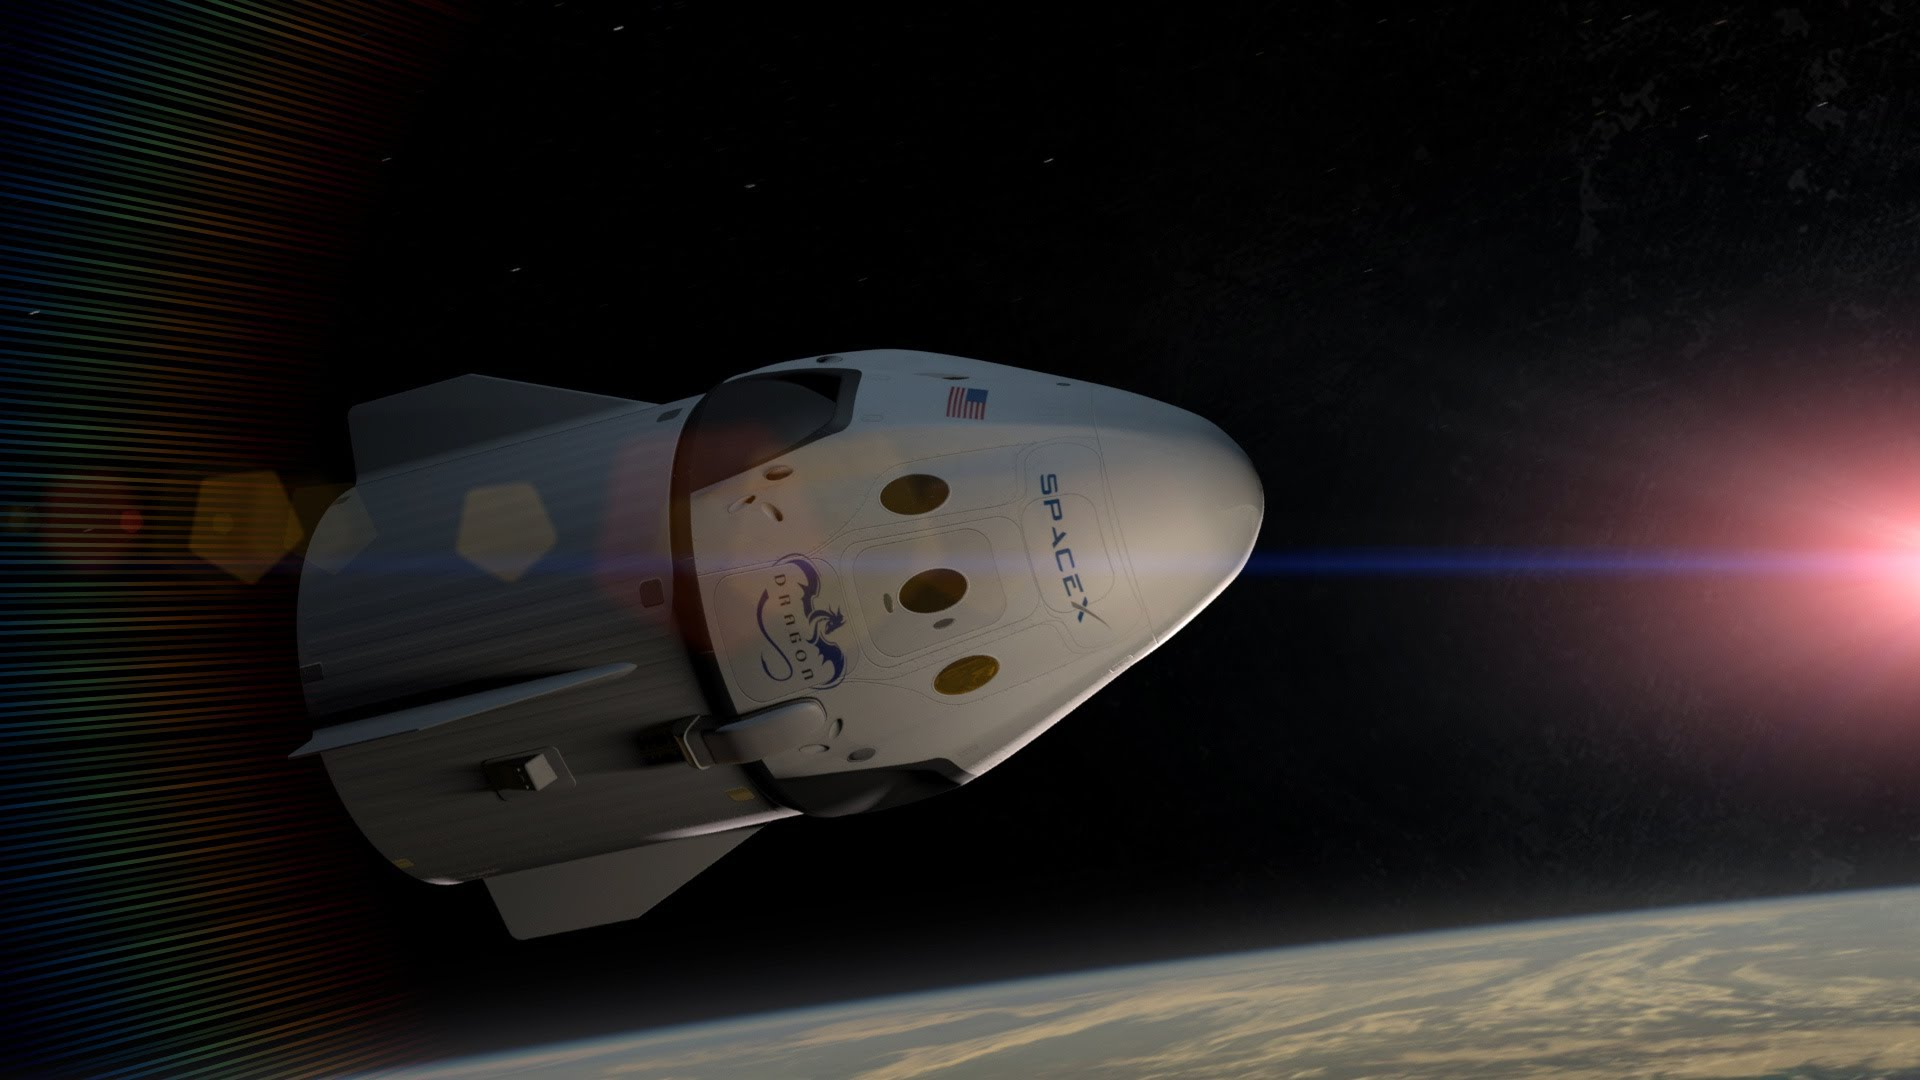

Image credits - Crew Dragon 2 capsule manufactured by SpaceX, and run by NASA and SpaceX.

# Model - Phase 1

The freefall of the capsule in the Martian Atmosphere and deceleration due to the drag force 

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# import math
import numpy as np
import matplotlib.pyplot as plt

# Schematic Diagrams

Representation of phases

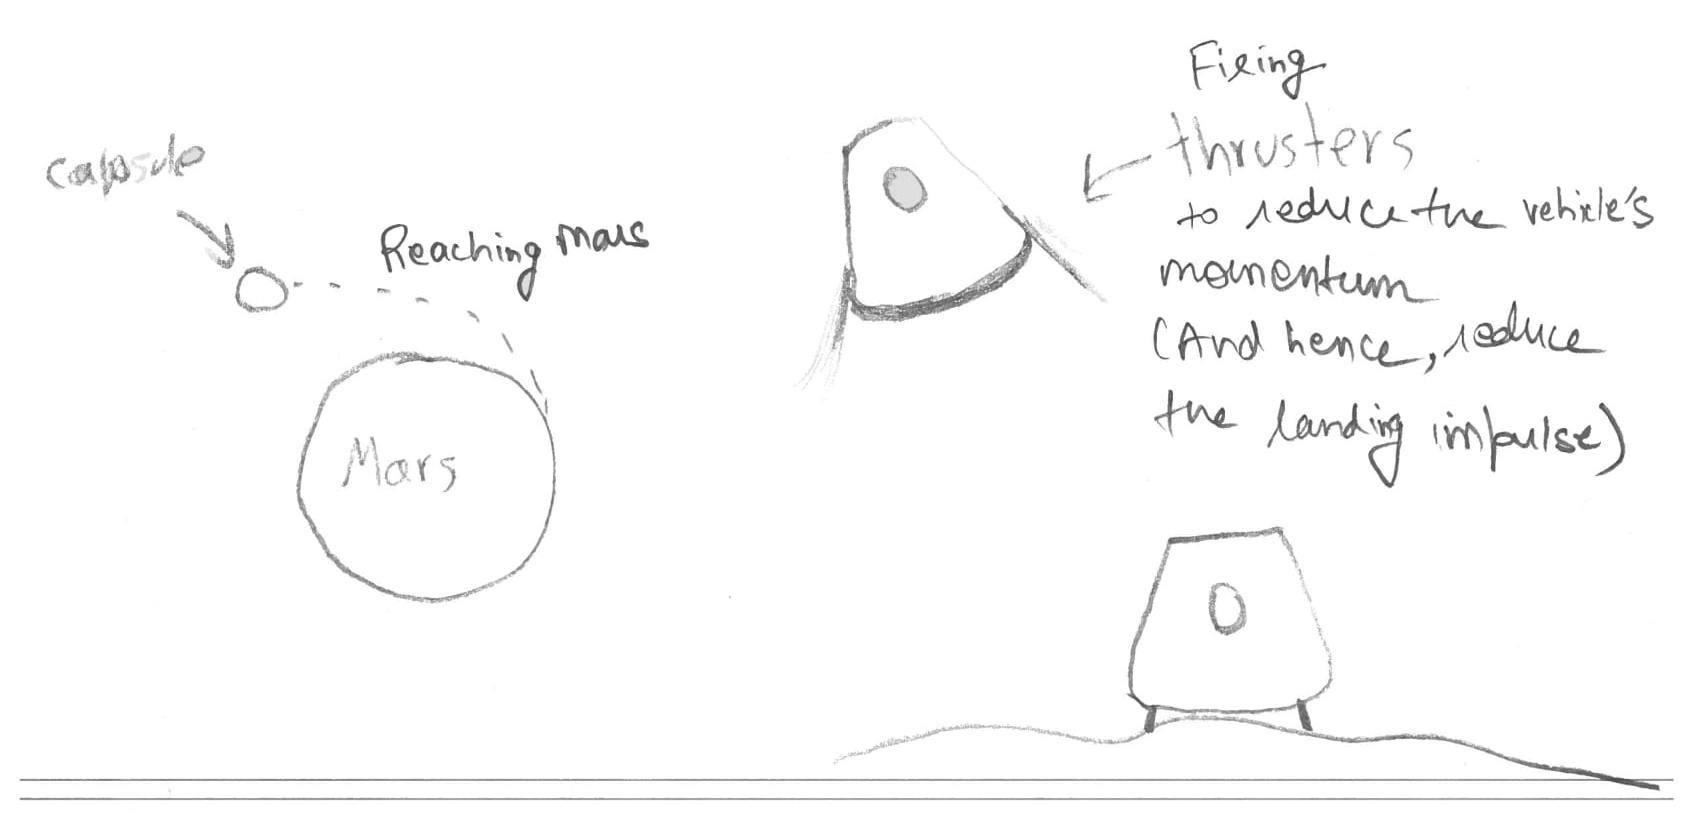

Force analysis

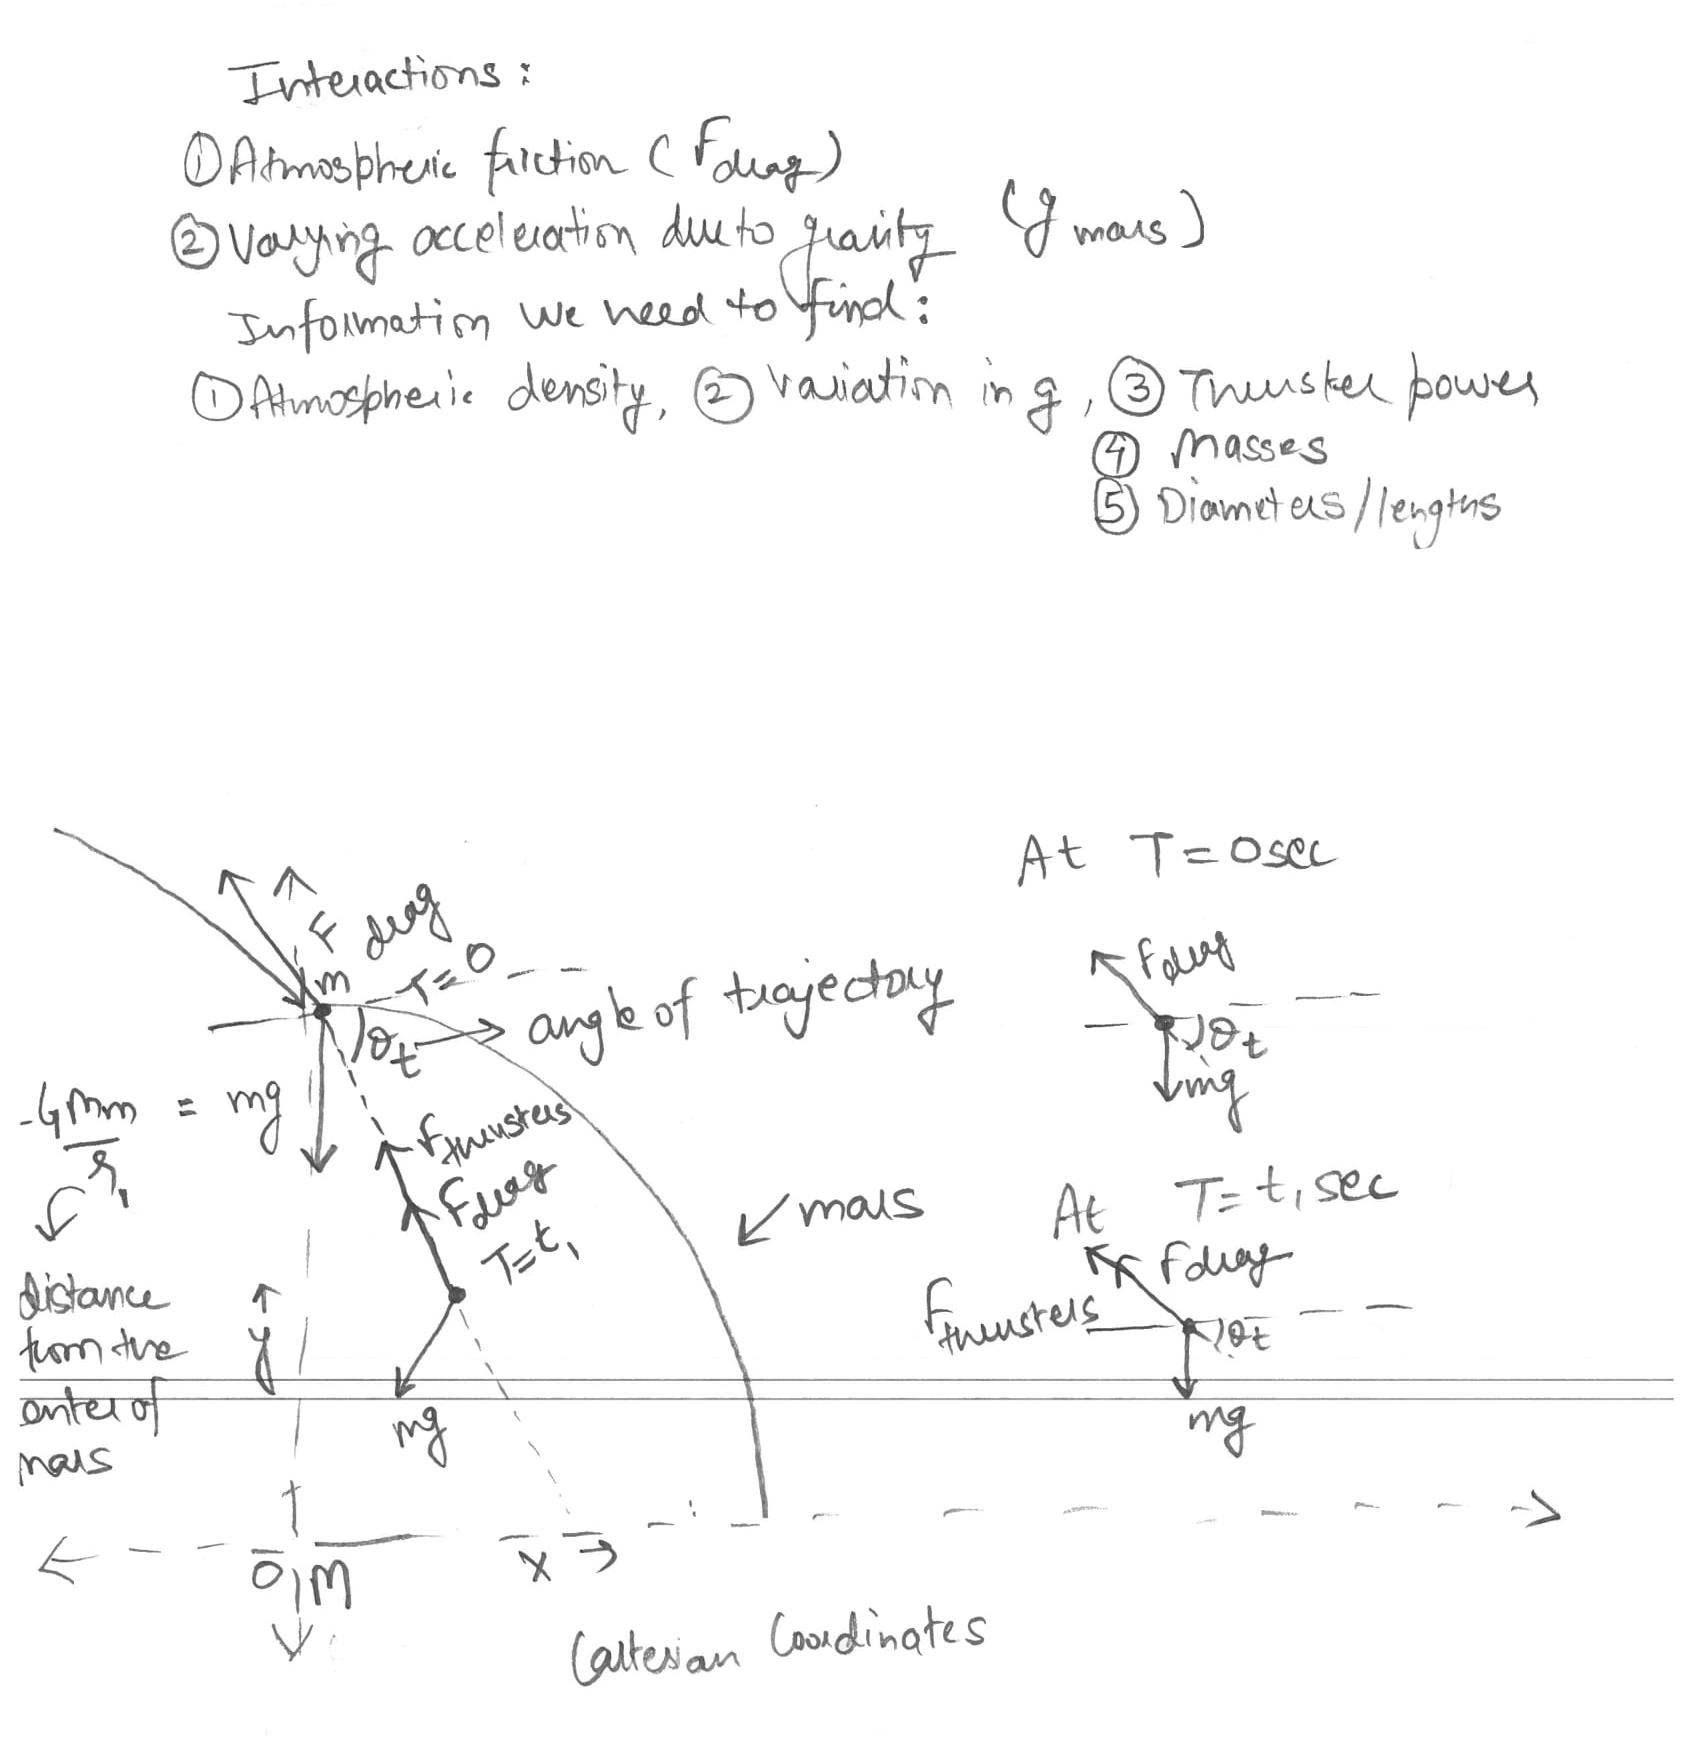

The point of origin has been moved to the surface of Mars (Not the center of Mars as depicted by this diagram)

Referenced Cartesian System

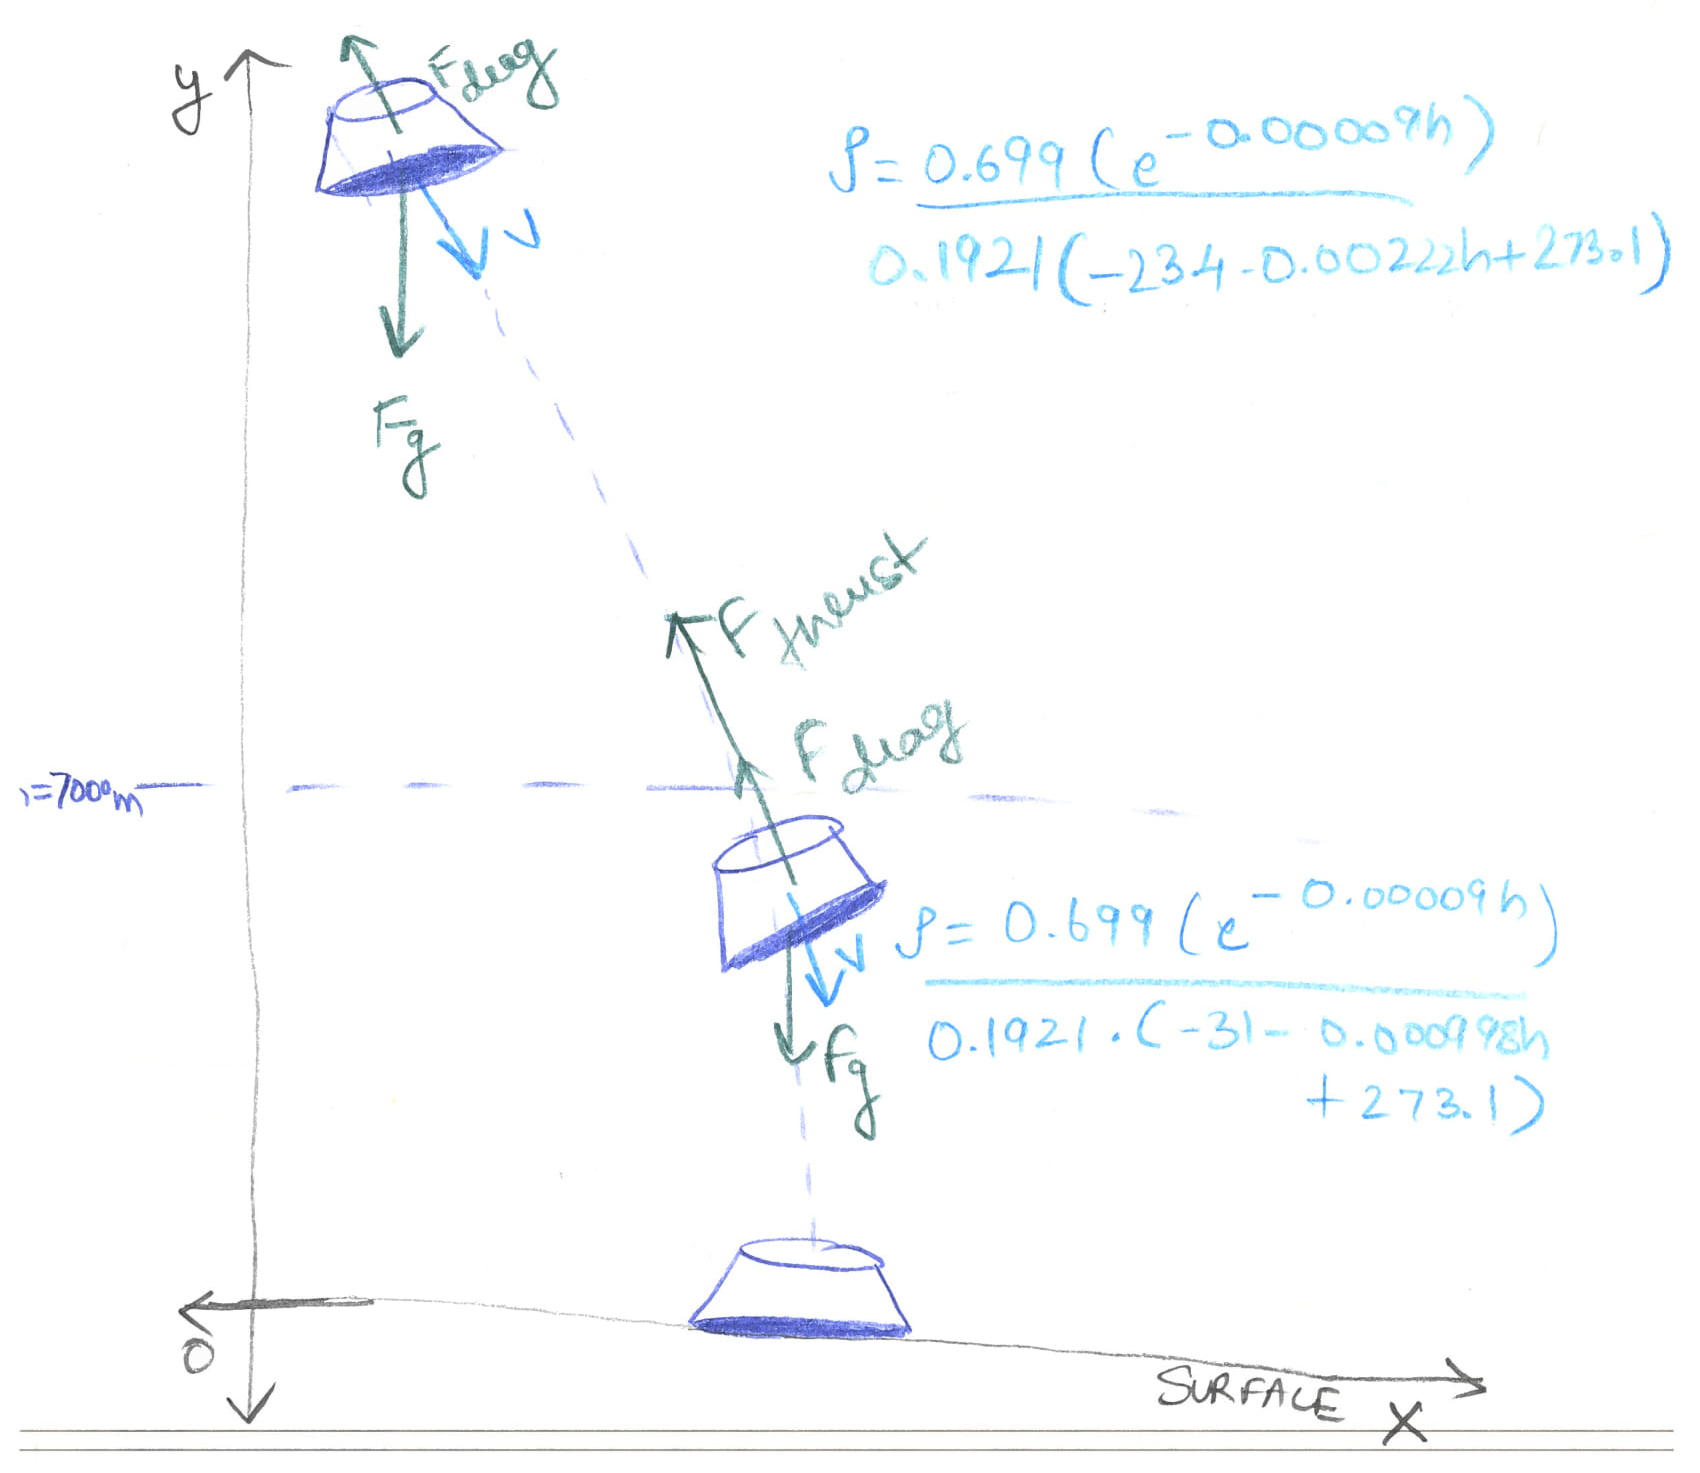

In [2]:
"""Definition of the units"""
m = UNITS.meter 
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree
N = UNITS.newton
radian = UNITS.radian

<Unit('radian')>

In [3]:
"""Definition of the variables. Source: Wikipedia"""
params = Params(g = 0 * m/s**2,
                m_capsule = 8857 * kg,
                m_mars = 6139e23 * kg,
                radius_capsule = 1.85 * m,
                radius_mars = 3389e3 * m,
                C_d = 0.42 ,
                G = 6.67e-11 * N * (m**2) / (kg**2),
                t_end = 100000 * s,
                y = 2e5 * m,
                x = 0 * m,
                θ = 347 * degree,
                v = 5600 * m / s)

,values
g,0.0 meter / second ** 2
m_capsule,8857 kilogram
m_mars,6.139e+26 kilogram
radius_capsule,1.85 meter
radius_mars,3389000.0 meter
C_d,0.42
G,6.67e-11 meter ** 2 * newton / kilogram ** 2
t_end,100000 second
y,200000.0 meter
x,0 meter


Modeling assumptions:

(i) We have assumed that the surface of Mars is flat
    
    The trajectory of the capsule is small relative to the curvature of the surface of Mars
   
(ii) We have assumed the acceleration due to gravity to be constant
    
    The change in gravitational force is very small which is why it can be neglected
    
(iii) We have assumed that there is no change in mass of the capsule as the thrusters burn fuel.
    
    This consideration would make the model exponentially more complicated. We were not sure about the engine
    design of the Dragon capsule - the fuel burn rate

In [4]:
def make_State(params):
    unpack(params)
    state = State(x=x, y=y, vx= v*np.cos(θ), vy = v*np.sin(θ))
    return state

In [5]:
State = make_State(params)

,values
x,0 meter
y,200000.0 meter
vx,5456.472362797317 meter / second
vy,-1259.7259043256458 meter / second


In [6]:
def make_system_phase1(params):
    """Make a system object.
    
    params: Params object
               
    returns: System object
    """
    unpack(params)
    
    init = State
    area_heat_shield = np.pi * (radius_capsule)**2
    g_mars = 3.711 *m/s**2
    
    return System(params, init=init, area_heat_shield=area_heat_shield, g_mars=g_mars)

In [7]:
System = make_system_phase1(params)

,values
g,0.0 meter / second ** 2
m_capsule,8857 kilogram
m_mars,6.139e+26 kilogram
radius_capsule,1.85 meter
radius_mars,3389000.0 meter
C_d,0.42
G,6.67e-11 meter ** 2 * newton / kilogram ** 2
t_end,100000 second
y,200000.0 meter
x,0 meter


In [8]:
"""Scalars to vectors"""
def make_v(vx, vy):
    v = Vector(vx, vy)
    
    return v

In [9]:
"""Initial velocity vector"""
v= make_v(State.vx, State.vy)

<Quantity([ 5456.4723628  -1259.72590433], 'meter / second')>

In [10]:
"""Updating atmospheric denisty as height of the capsule changes. Source of equations: NASA"""
def update_rho(State):
    x, y, vx, vy = State
    y = y/m
    if y > 7000:
        
        rho = 0.699 * 2.718**(- 0.00009 * y) / (0.1921 * (-23.4 - 0.00222 * y + 273.1))
        
    if y <= 7000:
        rho = 0.699 * 2.718**(- 0.00009 * y) / (0.1921 * (-31 - 0.000998 * y + 273.1))
    rho = rho * kg/m**3
    return rho

In [11]:
"""Determining the drag force acting on the capsule as it experiences drag in the Martian atmosphere"""
def drag_force(vx, vy, System):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    
    v=make_v(vx,vy)
    
    unpack(System)
    rho = update_rho(State)
    v_mag = v.mag *m/s
    mag = rho * v_mag**2 * C_d * area_heat_shield / 2

    direction =  -v.hat()
    f_drag = direction * mag
    return f_drag

In [12]:
def slope_func_phase1(State, t, System):
    """Computes derivatives of the state variables.
    
    state: State (r, θ)
    t: time
    
    returns: sequence (v, a)
    """
    x, y, vx, vy = State
    unpack(System)
    v = make_v(vx, vy)
    a_drag = drag_force(vx,vy, System) / m_capsule

    a_gravity = Vector(0, -g_mars)
    a_force = a_drag + a_gravity

    dxdt = vx
    dydt = vy
    dvxdt = a_force.x
    dvydt = a_force.y
    
    return dxdt, dydt, dvxdt, dvydt

In [13]:
"""The height at which the capsule transitions from phase 1 to phase 2 is being varied so as to land 
   smoothly on the surface of Mars"""
def event_func(State, t, System):
    """Stop when the θ is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: θ
    """
    x, y, vx, vy = State
    return y - 150161.7165 * m

In [14]:
results, details = run_ode_solver(System, slope_func_phase1, events=event_func)
details.message

'A termination event occurred.'

# Results - Phase 1

In [15]:
results

,x,y,vx,vy
0.000000e+00,0.000000,200000.000000,5456.472363,-1259.725904
3.174304e-07,0.001732,199999.999600,5456.472363,-1259.725906
3.491734e-06,0.019053,199999.995601,5456.472363,-1259.725917
3.523478e-05,0.192258,199999.955614,5456.472363,-1259.726035
3.526652e-04,1.924308,199999.555738,5456.472363,-1259.727213
3.526969e-03,19.244810,199995.556962,5456.472363,-1259.738993
3.527001e-02,192.449834,199955.567147,5456.472363,-1259.856791
3.527004e-01,1924.500075,199555.463329,5456.472364,-1261.034776
3.527004e+00,19245.002494,195533.859110,5456.472371,-1272.814620
3.527005e+01,192450.027923,153261.212536,5456.472442,-1390.613061


Time required for the completion of phase 1 (Just before the the thrusters are fired)

In [16]:
t_final = get_last_label(results) * s

<Quantity(37.49232585553838, 'second')>

In [17]:
"""Sorting of the dataframe to individual components of position and velocity"""
temp1 = results['x']
temp2 = results['y']
temp3 = results['vx']
temp4 = results['vy']

,values
0.000000e+00,-1259.725904
3.174304e-07,-1259.725906
3.491734e-06,-1259.725917
3.523478e-05,-1259.726035
3.526652e-04,-1259.727213
3.526969e-03,-1259.738993
3.527001e-02,-1259.856791
3.527004e-01,-1261.034776
3.527004e+00,-1272.814620
3.527005e+01,-1390.613061


In [18]:
x1 = temp1.values
y1 = temp2.values
vx1 = temp3.values
vy1 = temp4.values

array([-1259.72590433, -1259.7259055 , -1259.72591728, -1259.72603508,
       -1259.72721307, -1259.73899291, -1259.85679135, -1261.03477575,
       -1272.81461978, -1390.61306096, -1398.85994597])

In [19]:
xf=x1[10]
yf=y1[10]
vxf=vx1[10]
vyf=vy1[10]

-1398.8599459666273

Position of capsule during phase 1

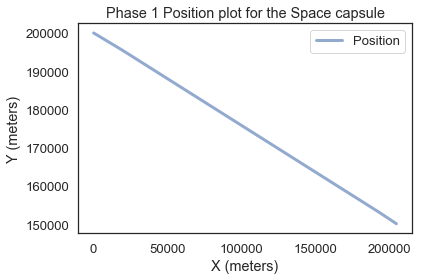

In [20]:
plot(results.x, results.y, label='Position')

decorate(title='Phase 1 Position plot for the Space capsule',
         xlabel='X (meters)',
         ylabel='Y (meters)')

The graph shows the position of the capsule during the first 37.5 seconds of landing flight.

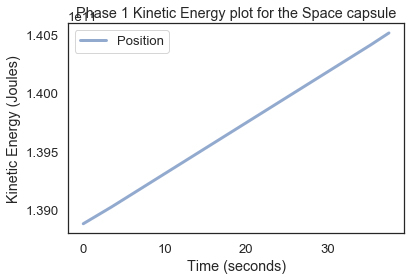

In [21]:
plot(results.index, (0.5 * m_capsule * (results.vx ** 2 + results.vy ** 2)), label='Position')

decorate(title='Phase 1 Kinetic Energy plot for the Space capsule',
         xlabel='Time (seconds)',
         ylabel='Kinetic Energy (Joules)')

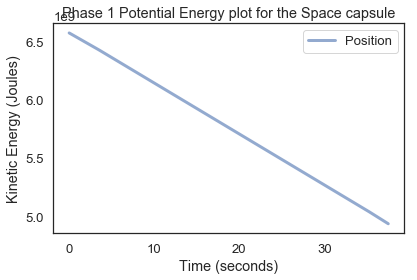

In [22]:
plot(results.index, m_capsule * g_mars * results.y , label='Position')

decorate(title='Phase 1 Potential Energy plot for the Space capsule',
         xlabel='Time (seconds)',
         ylabel='Kinetic Energy (Joules)')

# Interpretation - Phase 1

Phase 1 simulation helps us understand the motion of the capsule before the thrusters are fired. During this phase, the capsule falls for 37.5 seconds starting from a height of 200000 meters. The drag from the atmosphere slows it down until this phase ends at the height of 150161.7 meters. The thrusters are ignited at this point.

# Model - Phase 2

Controlled deceleration of the capsule and propulsive landing on the surface.

In [23]:
"""Re-definition of the state for phase 2 based on the result of phase 1"""
State.x=xf
State.y=yf
State.vx=vxf
State.vy = vyf

In [24]:
"""Definition of the thrust force produced by the capsule thrusters"""
def thrust_force(vx,vy, System):
    """Computes thrust produced by the engine opposite to the direction of motion.
    
    V: velocity
    system: System object with
    
    returns: Vector thrust force
    """
    v = make_v(vx, vy)
    unpack(System)
    mag = 2.92e5 * N
    direction = - v.hat()
    f_thrust = direction*mag
    return f_thrust

In [25]:
def slope_func_phase2(State, t, System):
    """Computes derivatives of the state variables.
    
    state: State (r, θ)
    t: time
    
    returns: sequence (v, a)
    """
    x, y, vx, vy = State
    unpack(System)
    v = make_v(vx, vy)
    a_drag = drag_force(vx,vy, System) / m_capsule
    a_drag = a_drag *s**2 / m**2 

    a_gravity = Vector(0, -g_mars)

    a_thrust = thrust_force(vx,vy, System) / m_capsule

    a_force = a_drag + a_gravity + a_thrust
    

    
    dxdt = vx
    dydt = vy
    dvxdt = a_force.x
    dvydt = a_force.y
    return dxdt, dydt, dvxdt, dvydt

In [26]:
"""Ends the simulation on touchdown"""
def event_func2(State, t, System):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = State
    return y

In [27]:
results2, details = run_ode_solver(System, slope_func_phase2, events=event_func2, max_step=5)
details.message

'A termination event occurred.'

# Results - Phase 2

In [28]:
results2

,x,y,vx,vy
0.000000,204575.841415,1.501617e+05,5456.472446,-1398.859946
0.233152,205847.163045,1.498357e+05,5449.026856,-1397.815780
2.564676,218464.914508,1.465889e+05,5374.586674,-1387.312873
7.564676,244938.941033,1.397094e+05,5215.046599,-1364.408538
12.564676,270615.611882,1.329457e+05,5055.645367,-1340.973054
17.564676,295495.636054,1.263005e+05,4896.388959,-1316.991133
22.564676,319579.753488,1.197767e+05,4737.283776,-1292.446569
27.564676,342868.737275,1.133770e+05,4578.336686,-1267.322156
32.564676,365363.396112,1.071045e+05,4419.555073,-1241.599586
37.564676,387064.577018,1.009621e+05,4260.946891,-1215.259345


In [29]:
results2.index += 37.49 

Total time of desent

In [30]:
t_final = get_last_label(results2) * s

<Quantity(215.37370828873065, 'second')>

Total run time for the thrusters

In [31]:
t_final-37.49*s

<Quantity(177.88370828873065, 'second')>

Position of capsule in phase 2

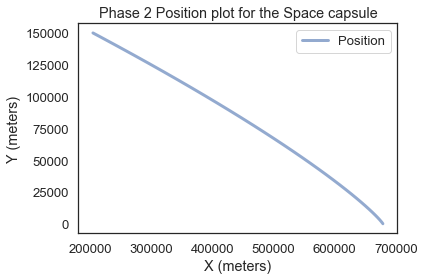

In [32]:
plot(results2.x, results2.y, label='Position')


decorate(title='Phase 2 Position plot for the Space capsule',
         xlabel='X (meters)',
         ylabel='Y (meters)')

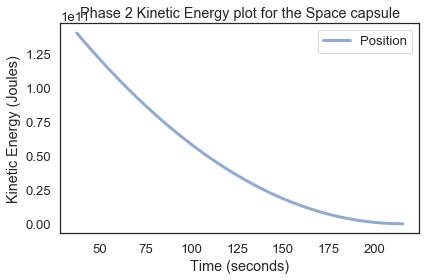

In [33]:
plot(results2.index, (0.5 * m_capsule * (results2.vx ** 2 + results2.vy ** 2)), label='Position')

decorate(title='Phase 2 Kinetic Energy plot for the Space capsule',
         xlabel='Time (seconds)',
         ylabel='Kinetic Energy (Joules)')

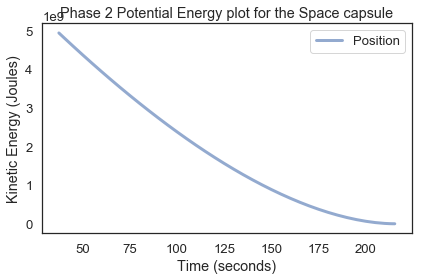

In [34]:
plot(results2.index, m_capsule * g_mars * results2.y, label='Position')

decorate(title='Phase 2 Potential Energy plot for the Space capsule',
         xlabel='Time (seconds)',
         ylabel='Kinetic Energy (Joules)')

# Interpretation - Phase 2

During phase 2, the thrusters are fired for a total of 177.9 seconds. At the end of this period, the capsule touches down on the surface of Mars at a speed of 0.077m/s vertically down and 0.167m/s horizontally. According to the graph, we can interpret how the capsule lands vertically down. 

# Results - Phase 1 and Phase 2

Position of capsule during entry and landing to Mars (Green line -> phase1, Blue line -> phase2)

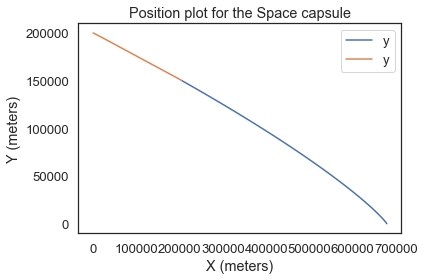

In [35]:
plt.plot(results2.x, results2.y)
plt.plot(results.x, results.y)

decorate(title='Position plot for the Space capsule',
         xlabel='X (meters)',
         ylabel='Y (meters)')

plt.show()

In [36]:
V2=results2.vx**2+results2.vy**2
V_mag2 = sqrt(V2)

V1=results.vx**2+results.vy**2
V_mag1 = sqrt(V1)
V = V_mag1.append(V_mag2)

0.000000e+00    5600.000000
3.174304e-07    5600.000000
3.491734e-06    5600.000003
3.523478e-05    5600.000029
3.526652e-04    5600.000294
3.526969e-03    5600.002944
3.527001e-02    5600.029445
3.527004e-01    5600.294578
3.527004e+00    5602.958842
3.527005e+01    5630.887691
3.749233e+01    5632.930029
3.749000e+01    5632.930029
3.772315e+01    5625.458437
4.005468e+01    5550.749402
4.505468e+01    5390.577120
5.005468e+01    5230.464493
5.505468e+01    5070.413246
6.005468e+01    4910.425207
6.505468e+01    4750.502316
7.005468e+01    4590.646640
7.505468e+01    4430.860377
8.005468e+01    4271.145879
8.505468e+01    4111.505663
9.005468e+01    3951.942430
9.505468e+01    3792.459089
1.000547e+02    3633.058778
1.050547e+02    3473.744895
1.100547e+02    3314.521135
1.150547e+02    3155.391524
1.200547e+02    2996.360472
1.250547e+02    2837.432831
1.300547e+02    2678.613963
1.350547e+02    2519.909829
1.400547e+02    2361.327096
1.450547e+02    2202.873271
1.500547e+02    2044

Velocity of capsule during desent

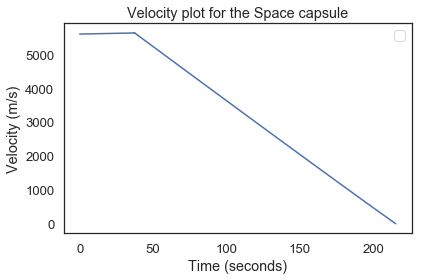

In [37]:
plt.plot(V)

decorate(title='Velocity plot for the Space capsule',
         xlabel='Time (seconds)',
         ylabel='Velocity (m/s)')

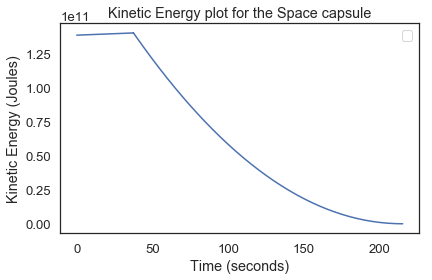

In [38]:
plt.plot(0.5 * m_capsule * (V ** 2))

decorate(title='Kinetic Energy plot for the Space capsule',
         xlabel='Time (seconds)',
         ylabel='Kinetic Energy (Joules)')

In [39]:
px1 = results.x
px2 = results2.x
py1 = results.y
py2 = results2.y

positionx = px1.append(px2)

positiony = py1.append(py2)

positiony= positiony + params.radius_mars / m

0.000000e+00    3.589000e+06
3.174304e-07    3.589000e+06
3.491734e-06    3.589000e+06
3.523478e-05    3.589000e+06
3.526652e-04    3.589000e+06
3.526969e-03    3.588996e+06
3.527001e-02    3.588956e+06
3.527004e-01    3.588555e+06
3.527004e+00    3.584534e+06
3.527005e+01    3.542261e+06
3.749233e+01    3.539162e+06
3.749000e+01    3.539162e+06
3.772315e+01    3.538836e+06
4.005468e+01    3.535589e+06
4.505468e+01    3.528709e+06
5.005468e+01    3.521946e+06
5.505468e+01    3.515301e+06
6.005468e+01    3.508777e+06
6.505468e+01    3.502377e+06
7.005468e+01    3.496104e+06
7.505468e+01    3.489962e+06
8.005468e+01    3.483953e+06
8.505468e+01    3.478080e+06
9.005468e+01    3.472348e+06
9.505468e+01    3.466758e+06
1.000547e+02    3.461316e+06
1.050547e+02    3.456025e+06
1.100547e+02    3.450888e+06
1.150547e+02    3.445910e+06
1.200547e+02    3.441095e+06
1.250547e+02    3.436447e+06
1.300547e+02    3.431972e+06
1.350547e+02    3.427674e+06
1.400547e+02    3.423559e+06
1.450547e+02  

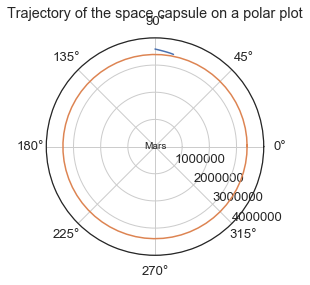

In [40]:
xs = positionx
ys = positiony
rs = []
thetas = []
r_m = params.radius_mars / m 
circle_theta = linrange(0, 2*pi+.1, .1)
circle_mars = [r_m for i in range(len(circle_theta))]

for x, y in zip(xs, ys):
    rs.append(sqrt(x**2+y**2))
    thetas.append(np.arctan2(y,x))

ax = plt.subplot(111, projection='polar')
ax.plot(thetas, rs)
ax.plot(circle_theta, circle_mars)

# ax.grid(True)

ax.set_title("Trajectory of the space capsule on a polar plot", va='bottom')
ax.set_rmax(4000000) # sets max r value (plotting boundary)
ax.set_rticks([1e6, 2e6, 3e6, 4e6])  # less radial ticks

ax.set_rlabel_position(-45)  # get radial labels away from plotted line
plt.text(.5, .5, 'Mars', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.show()

# Interpretation - Phase 1 and Phase 2

The total duration of the landing process is 215.37 seconds. The height of the capsule w.r.t. the Martian surface changes from 200000 meters to touch down level.

On the x-y position graph, the two phases of the landing process are shown. The effect of firing the thrusters is quite evident from the latter part of the graph.

On the velocity-time graph, we observe that the velocity of the capsule slightly increases during phase 1 - a decrease in the x-component of velocity, but a small increase in the y-component.

On the final graph, the trajectory of the capsule can be seen as observed from space. The capsule enters the Martian atmosphere at (200000, 90°). This graph is plotted in a polar plane so as to account for the entry trajectory relative to the curvature of Mars.